In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32 #storing 32 images
CHANNELS = 3 #RGB CHANNEL
EPOCHS=50 

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 15000 files belonging to 3 classes.


In [16]:
class_names = dataset.class_names
class_names

['Adenocarcinoma', 'Benign_Tissue', 'Squamous_Cell_Carcinoma']

In [5]:
len(dataset) #Every element in the dataset is a batch of 32 images, 15000/32 Ceiling Function

469

In [6]:
for image_batch, label_batch in dataset.take(1):#takes 1 batch
    print(image_batch.shape)
    print(label_batch.numpy()) #label_batch gives you tensor, which is converted to numpy
#label batch is title which gives tensor
#32,256,256,3 (3 refers to RGB Channels)
#0,1,2 corresponds to classes

(32, 256, 256, 3)
[2 2 1 2 0 0 1 2 1 1 0 1 0 0 2 2 0 0 0 2 0 0 2 2 1 1 2 1 2 1 1 0]


In [7]:
for image_batch, label_batch in dataset.take(1):
    #print(image_batch[0]) #printing 1st image, this is tensor
    print(image_batch[0].numpy()) #printing 1st image, tensor converted to numpy
#Every color is b/w 0-255, and so are the numbers printed in this array

[[[122.  78. 213.]
  [124.  80. 217.]
  [124.  80. 217.]
  ...
  [ 98.  61. 203.]
  [103.  66. 208.]
  [102.  63. 206.]]

 [[121.  77. 212.]
  [124.  80. 217.]
  [121.  77. 214.]
  ...
  [ 98.  61. 203.]
  [ 99.  62. 204.]
  [107.  68. 211.]]

 [[119.  75. 210.]
  [125.  81. 218.]
  [119.  75. 212.]
  ...
  [ 96.  59. 199.]
  [ 90.  53. 193.]
  [ 99.  60. 201.]]

 ...

 [[214. 144. 242.]
  [214. 144. 243.]
  [211. 140. 242.]
  ...
  [159. 105. 227.]
  [156. 101. 228.]
  [154. 101. 231.]]

 [[212. 142. 240.]
  [213. 143. 242.]
  [211. 140. 242.]
  ...
  [154. 101. 219.]
  [153.  99. 223.]
  [153. 100. 230.]]

 [[213. 143. 241.]
  [216. 146. 245.]
  [215. 144. 246.]
  ...
  [158. 105. 221.]
  [154. 100. 224.]
  [150.  98. 225.]]]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape) #printing shape of 1st image

(256, 256, 3)


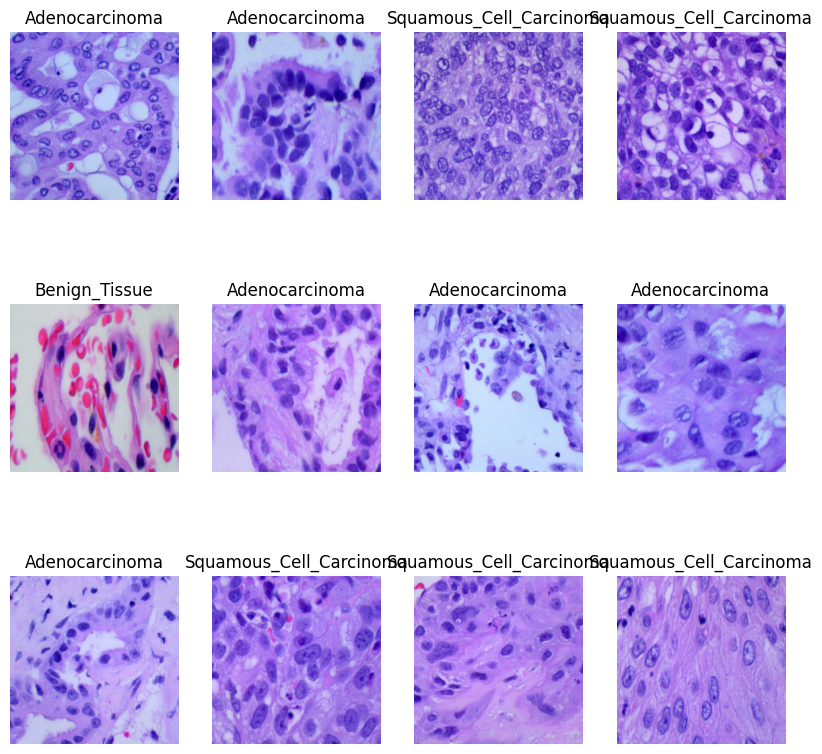

In [9]:
#visualising an image
plt.figure(figsize=(10,10)) #area of each image
for image_batch, label_batch in dataset.take(1): #take(1) means 1st batch of 32 images
    for i in range(12):
        ax = plt.subplot(3,4,i+1) #required otherwise only 1 image will show
        plt.imshow(image_batch[i].numpy().astype("uint8")) #this expects 3d array
        plt.title(class_names[label_batch[i]]) #displaying label
        plt.axis("off") #i dont want numbers on x-y axis
#.astype("uint8") converts the float into integer, which is necessary to show proper image
#i want to display label (which image is it)

In [10]:
#Dividing dataset
# 80% ==> training #80% for training dataset
# 20% ==> 10% validation, 10% test #10% will be used to validate the training model
#after each epoch, you do validation on each 10%
#after 50 epochs, then 10% final test data is used to measure accuracy and other metrics

In [11]:
len(dataset)

469

In [12]:
#sklearn used to split
train_size = 0.8
len(dataset)*train_size
# dataset.take(10) #will take 1st 10 samples
# i.e. 375 batches could be used as train dataset

375.20000000000005

In [13]:
train_ds = dataset.take(375) #first 375, arr[:375]
len(train_ds)

375

In [14]:
test_ds = dataset.skip(375) #take from 54 onwards, arr[54:]
#IT Is not test dataset
len(test_ds)

94

In [15]:
val_size = 0.1 #validation size
len(dataset)*val_size #10% of dataset is 6 samples

46.900000000000006

In [16]:
val_ds = test_ds.take(46)
len(val_ds)

46

In [17]:
test_ds = test_ds.skip(46) #THIS is the actual test dataset
len(test_ds)

48

In [18]:
#Validation, Test, Train datasets are splitted now
#val_ds=46, test_ds=48, train_ds=375

In [19]:
#function to take tensorflow dataset, split ratio, shufflesize
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)#seed could be any number, it used for checking Predictibility
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
#Basically training will run fast
#Saving time for loading images
#Caching and Prefetching dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#prefetch(buf.....: While Gpu is training
#cache will read an image from disc, and when you need that image for next iteration, it will keep it in its memory, which improves the performance of pipeline
#prefetch: if gpu is busy training, prefetch will load next set of batch from disc, which will improve performance

In [22]:
#Preprocessing
#scaling to get 0-1
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])
#data augmentation: An image with rotation/contrast, etc. might not work properly
#1 original image, get 4 new training samples (flip, contrast, rotation , zoom) and use all these to train, to make model more robust

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
#Using Convulational Neural Network to be used for Image classification
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), #Gpogle TESNORFLOW COV2D Layer
    #filters are sub-parameters used for detection (eye, nose, ears, hands)
    #In our case, we will be using 32 layers, 32 came from trial and error
    #(3,3) will be filter size
    #activation Layer popular one is relu (fast to compute)
    #kernelsize is size of filter
    #After Convulational layer, you have Pooling Layer
    layers.MaxPooling2D((2,2)), #4*4 matrix reduced to 2*2, by selectively choosing max value of 2*2 matrices parts in 4*4 matrix
    #It is done to preserving the features and reducing the size
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #32 and 64 are based on trial and error
    #Now you have to flatten the layers to get an array
    layers.Flatten(),
    layers.Dense(64, activation='relu'), #Dense layer of 64 neurons
    layers.Dense(n_classes, activation='softmax'), #softmax: normalise probability of classes
])
#Our Model architecture is: We have 3 neurons==n_classes & activation is softmax which is probabilities
#Hence, you would have 3 probabilities, and whichever would be the highest probability, that would be the CLASS
#print(np.argmax(batch_prediction[0])
model.build(input_shape=input_shape)

In [25]:
#Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
#Compile using Adam
#Define loss function
#In each epoch, what type of metric you will use; 
#Define optimizer (adam is popular)
#Accuracy is used to track training process
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
#record history of each epoch so that plots and charts can be done
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds #used in each epoch to track accuracy
)

Epoch 1/50
375/375 [==============================] - 1404s 3s/step - loss: 0.4685 - accuracy: 0.7860 - val_loss: 0.5698 - val_accuracy: 0.7378
Epoch 2/50
375/375 [==============================] - 1058s 3s/step - loss: 0.2556 - accuracy: 0.9015 - val_loss: 0.2182 - val_accuracy: 0.9110
Epoch 3/50
375/375 [==============================] - 1078s 3s/step - loss: 0.2051 - accuracy: 0.9219 - val_loss: 0.2468 - val_accuracy: 0.8947
Epoch 4/50
375/375 [==============================] - 1084s 3s/step - loss: 0.1656 - accuracy: 0.9404 - val_loss: 0.1434 - val_accuracy: 0.9409
Epoch 5/50
375/375 [==============================] - 1057s 3s/step - loss: 0.1403 - accuracy: 0.9471 - val_loss: 0.1602 - val_accuracy: 0.9293
Epoch 6/50
375/375 [==============================] - 959s 3s/step - loss: 0.1432 - accuracy: 0.9429 - val_loss: 0.1211 - val_accuracy: 0.9497
Epoch 7/50
375/375 [==============================] - 966s 3s/step - loss: 0.1209 - accuracy: 0.9536 - val_loss: 0.1504 - val_accuracy: 0

In [28]:
scores = model.evaluate(test_ds) #gives a list having loss & accuracy

48/48 [==============================] - 293s 868ms/step - loss: 0.0231 - accuracy: 0.9889


In [29]:
history #tensorflow keras callback history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 375}

In [31]:
history.history.keys() #the parameters resulted in console from model training

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.7860240340232849,
 0.9015176892280579,
 0.9218645691871643,
 0.9403769373893738,
 0.9471313953399658,
 0.9428786039352417,
 0.9536357522010803,
 0.9520513415336609,
 0.9548032283782959,
 0.9574716687202454,
 0.9635590314865112,
 0.964643120765686,
 0.9663942456245422,
 0.9712308049201965,
 0.9730653762817383,
 0.9701467752456665,
 0.9793195724487305,
 0.9735656976699829,
 0.9809873104095459,
 0.9786524176597595,
 0.9814876317977905,
 0.9829886555671692,
 0.9817378520965576,
 0.9819046258926392,
 0.9857404828071594,
 0.9841561317443848,
 0.9866577982902527,
 0.9849066138267517,
 0.9871581196784973,
 0.9904102683067322,
 0.9834889769554138,
 0.9860740303993225,
 0.9899933338165283,
 0.9914109110832214,
 0.993328869342804,
 0.9879086017608643,
 0.9881587624549866,
 0.9902434945106506,
 0.9899099469184875,
 0.9911607503890991,
 0.9937458038330078,
 0.9910773634910583,
 0.9889926910400391,
 0.9931620955467224,
 0.9901601076126099,
 0.9967478513717651,
 0.9923282265663147,
 0.992745161056

In [33]:
#We want to plot all of these values using matplotlib
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

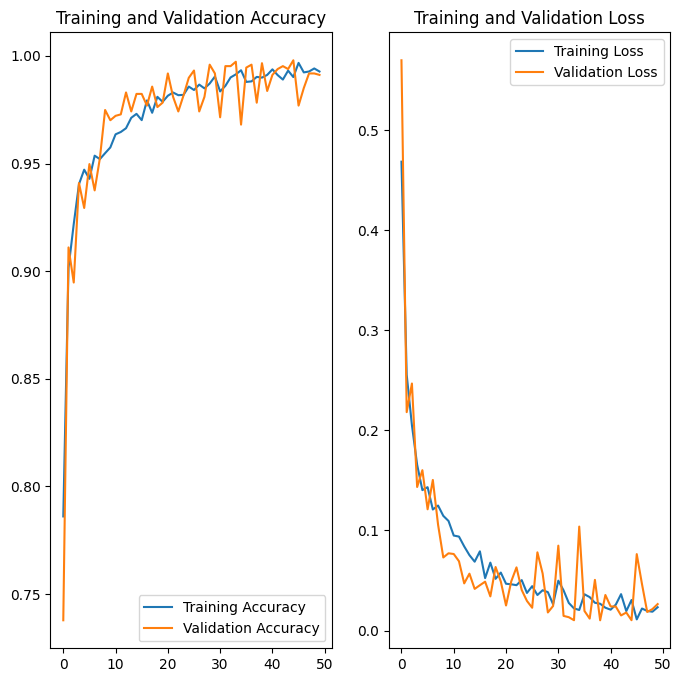

In [34]:
#Plotting Training Accuracy vs Validation Accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#X Axis shows epochs, Y shows accuracy

#Plotting loss charts
#Loss is basically an error, which can get propagated further
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: Benign_Tissue
1/1 [==============================] - 2s 2s/step
predicted label: Benign_Tissue


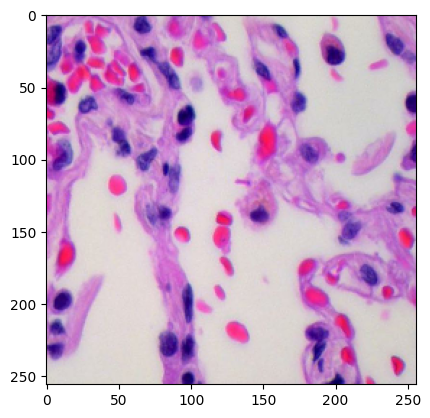

In [35]:
for images_batch, labels_batch in test_ds.take(1): #1st batch
    #print(images_batch[0].numpy()) #1st image
    #plt.imshow(images_batch[0].numpy().astype('uint8')) #showing image as it is
    first_image = images_batch[0].numpy().astype('uint8') #1st image as RGB array
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label]) #actual label

#I want to know predicted label...
    batch_prediction = model.predict(images_batch) #this will be prediction for 32 images
    #predict function expects images_batch
    #i want prediction of 1st image
    #print(batch_prediction[0]) #will print 3 probablilities as n_classes=3, softmax
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) #this will give INDEX of the MAX-PROBABILITY ITEM

In [29]:
#100% confidence means accuracy of prediction is 100%
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

def predict_single_img(model, img):
    # Convert the image to an array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Expand dimensions to create a batch of size 1 (required by the model)
    img_array = tf.expand_dims(img_array, 0)
    # Make predictions
    predictions = model.predict(img_array)
    # Get the predicted class index
    predicted_class = class_names[np.argmax(predictions[0])]
    # Calculate confidence level
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 83ms/step


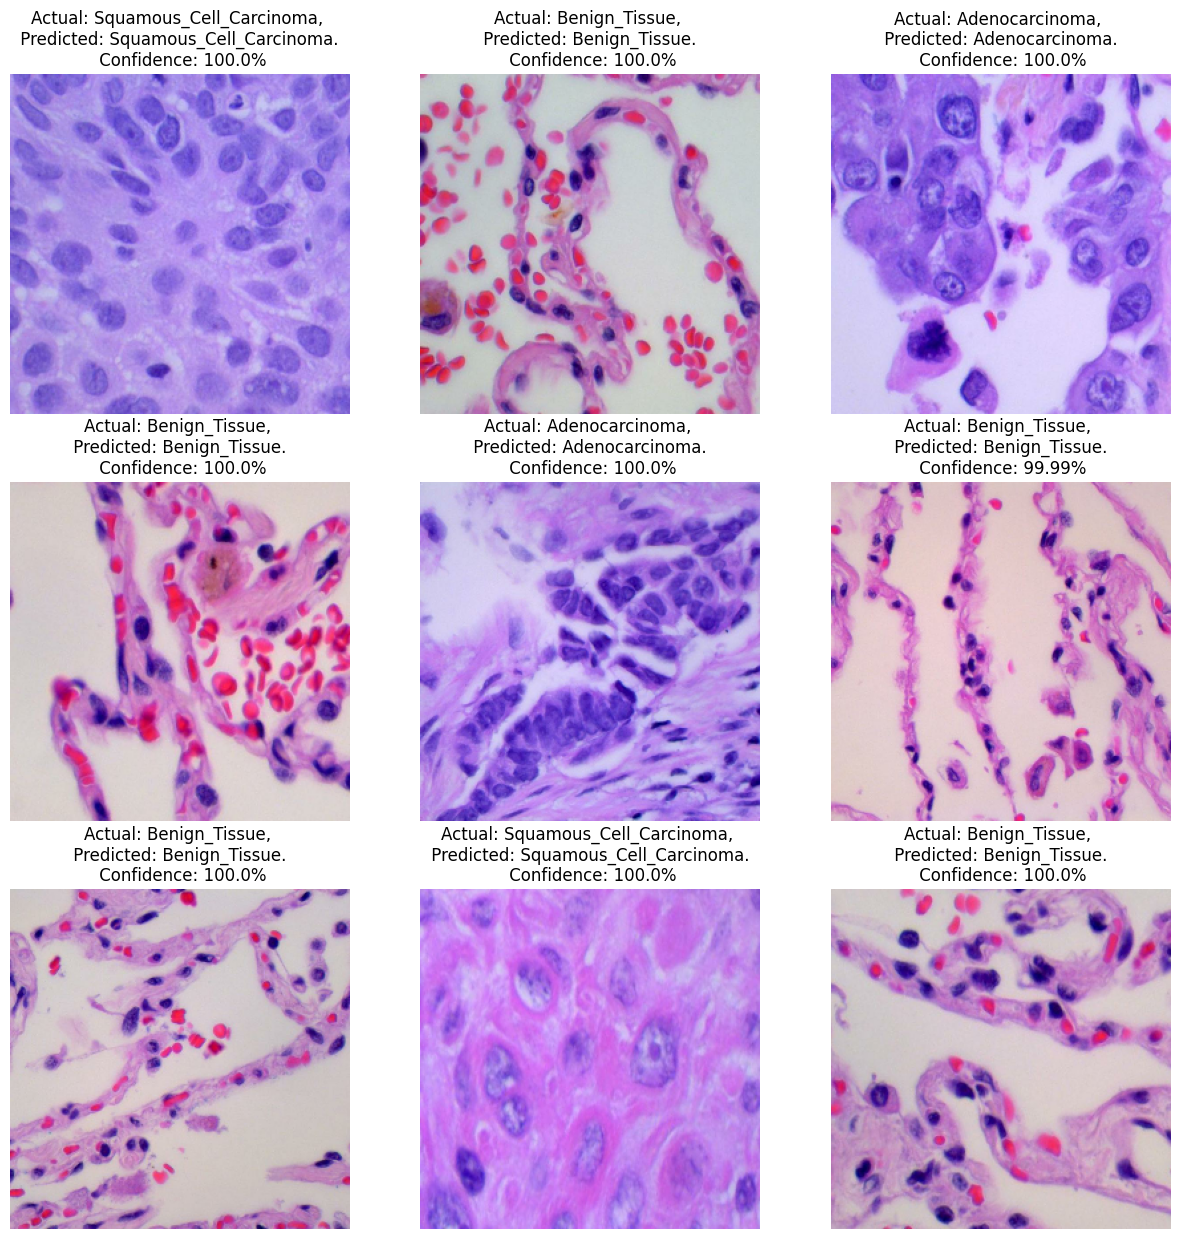

In [37]:
#for loop on first batch
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9): #running on only 1st 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")

In [39]:
model_version = 1
model.save(f"models/{model_version}.keras")

In [27]:
#Loading a model
model = tf.keras.models.load_model('models/1.keras')

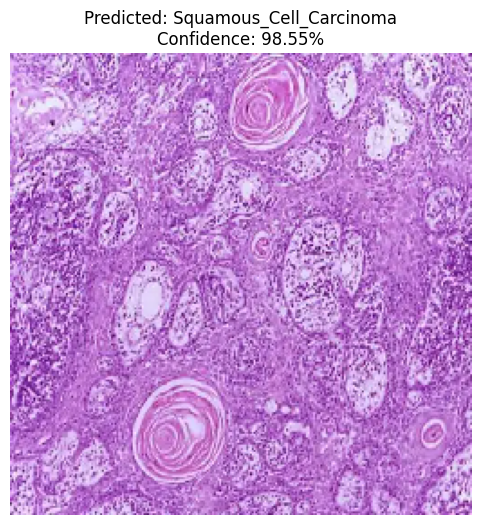

1/1 [==============================] - 0s 362ms/step
Predicted class: Lymphoma with confidence: 98.55%


In [28]:
#PREDICTING a Single image
from tensorflow.keras.preprocessing import image

height = 256
width = 256
img_path = 'custom_img.jpg'
img = image.load_img(img_path, target_size=(256,256))
img_array = image.img_to_array(img)
img_arrary = np.expand_dims(img_array, axis=0)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
plt.axis('off')
plt.show()
predicted_class, confidence = predict_single_img(model, img)
print(f"Predicted class: {predicted_class} with confidence: {confidence}%")